In [1]:

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir /kaggle
! cp kaggle.json /kaggle
! chmod 600 /kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d johnsmith88/heart-disease-dataset
! unzip heart-disease-dataset.zip


Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/kaggle’: File exists
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Dataset URL: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset
License(s): unknown
  0% 0.00/6.18k [00:00<?, ?B/s]
100% 6.18k/6.18k [00:00<00:00, 14.9MB/s]
Archive:  heart-disease-dataset.zip
  inflating: heart.csv               


In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency, f_oneway, f
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

In [3]:

data = pd.read_csv('heart.csv')


In [4]:

# Handle duplicates (if any)
data = data.drop_duplicates()



In [5]:

# Normalize Continuous Features
scaler = StandardScaler()
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
data[continuous_features] = scaler.fit_transform(data[continuous_features])




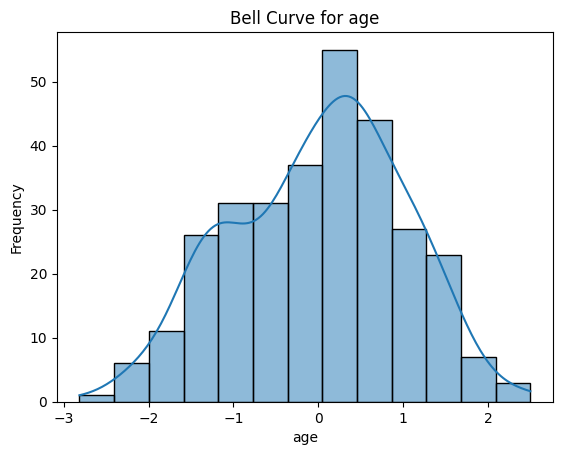

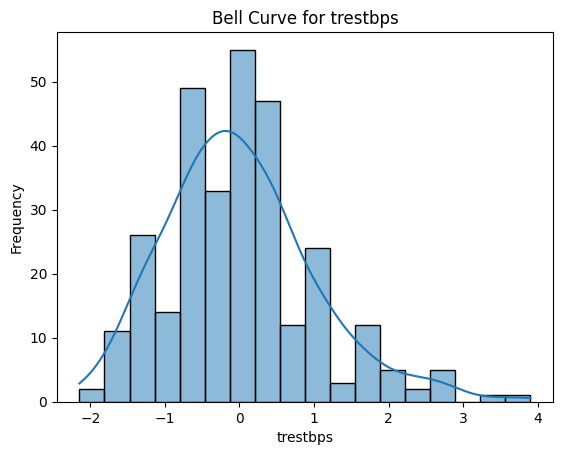

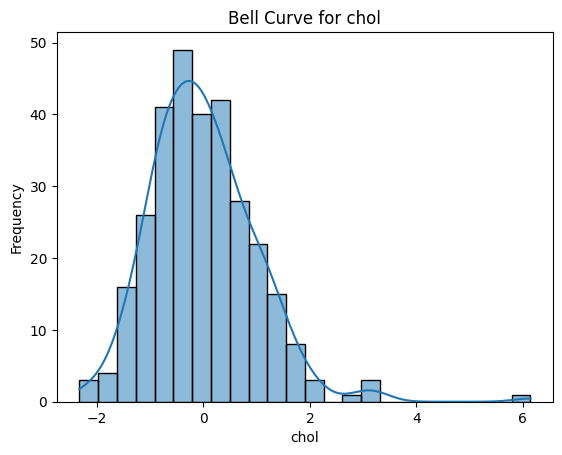

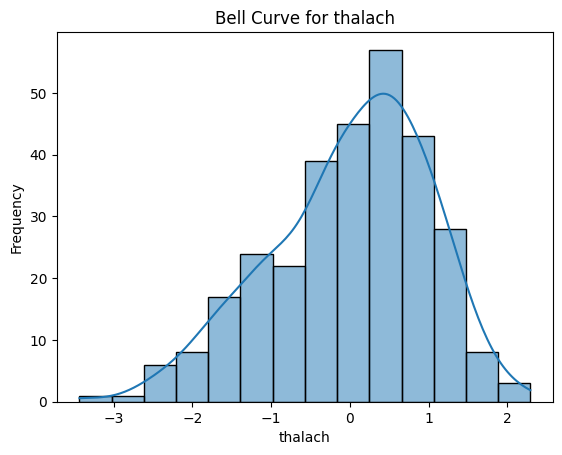

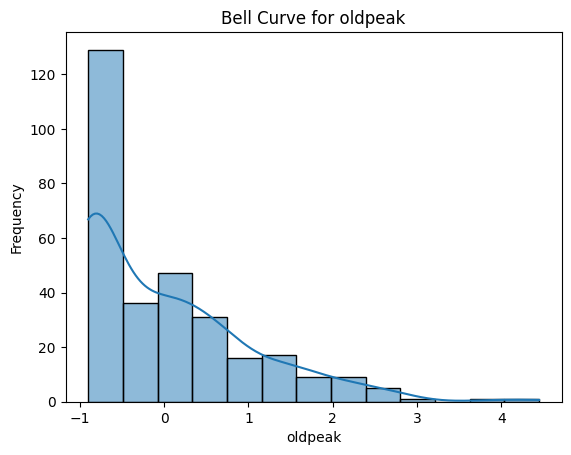

In [6]:
# Empirical Rule & Bell Curve
for col in continuous_features:
    sns.histplot(data[col], kde=True)
    plt.title(f"Bell Curve for {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()



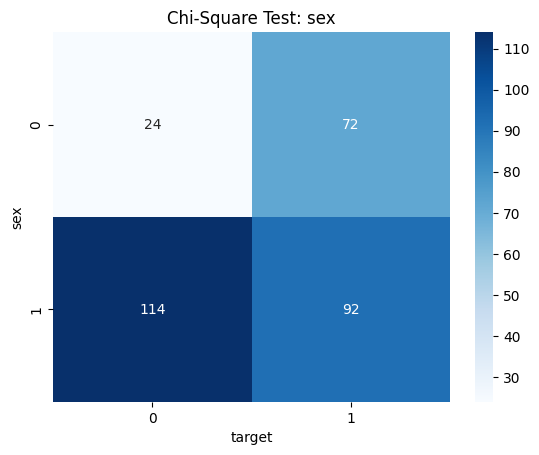

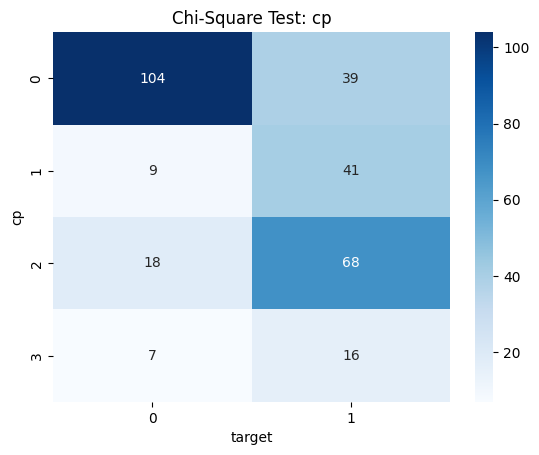

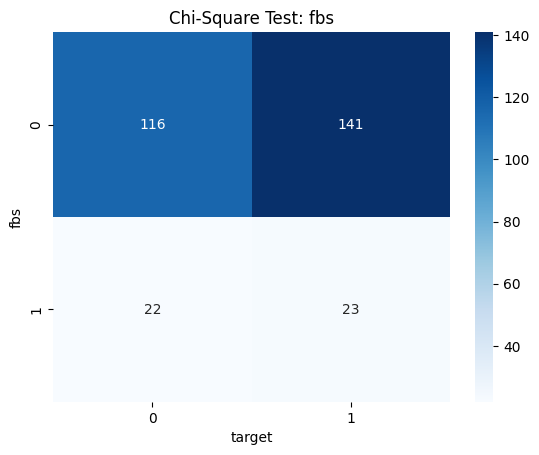

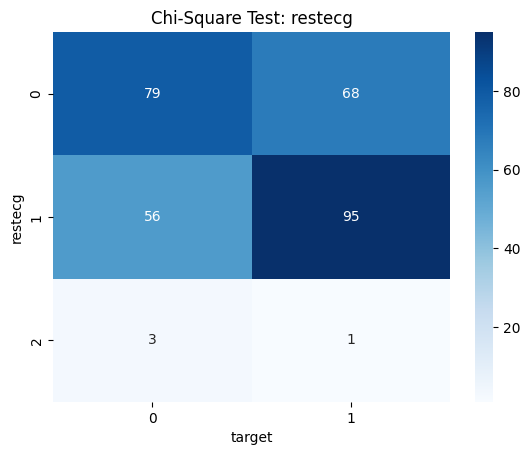

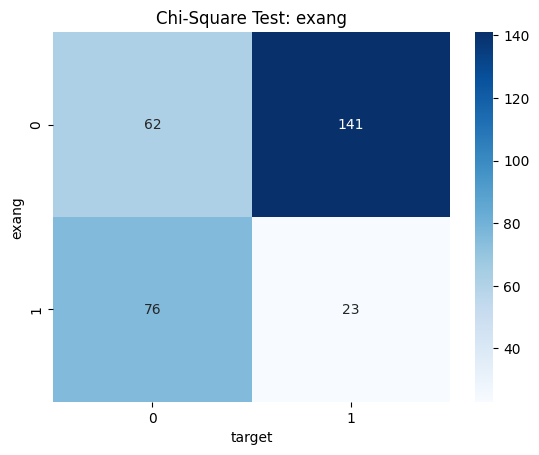

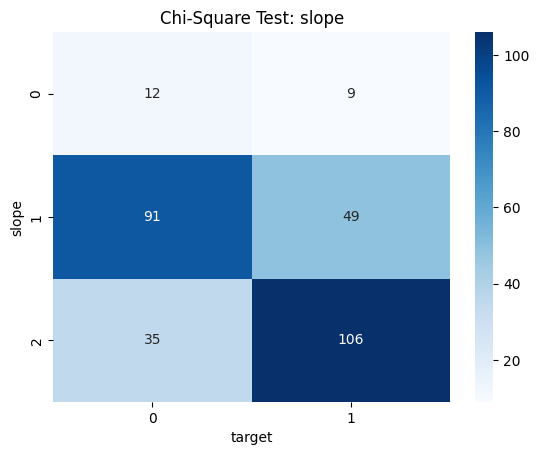

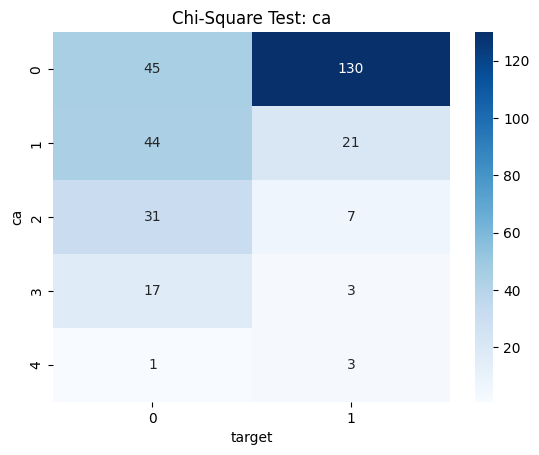

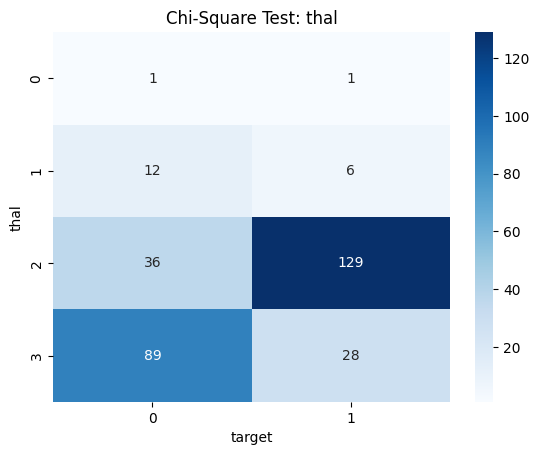


Significant Features (Chi-Square Test): ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [7]:

# Chi-Square Test
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
chi_square_results = {}
for col in categorical_features:
    contingency_table = pd.crosstab(data[col], data['target'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[col] = (chi2_stat, p_value, dof)

    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Chi-Square Test: {col}")
    plt.show()
    # Print significant features
significant_features = [key for key, (chi2_stat, p_value, dof) in chi_square_results.items() if p_value < 0.05]
print("\nSignificant Features (Chi-Square Test):", significant_features)



ANOVA Test Results for thalach by cp:
F-statistic: 17.6202, Critical Value: 2.6349, P-value: 1.4799e-10



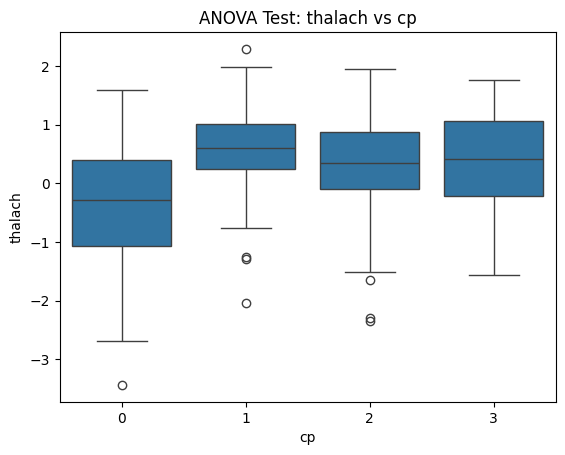

In [8]:
# ANOVA Test
categorical_feature = 'cp'
continuous_feature = 'thalach'
groups = [data[continuous_feature][data[categorical_feature] == category] for category in data[categorical_feature].unique()]
anova_result = f_oneway(*groups)
df_between = len(groups) - 1
df_within = data.shape[0] - len(groups)
critical_value = f.ppf(0.95, df_between, df_within)

print(f"ANOVA Test Results for {continuous_feature} by {categorical_feature}:")
print(f"F-statistic: {anova_result.statistic:.4f}, Critical Value: {critical_value:.4f}, P-value: {anova_result.pvalue:.4e}\n")

sns.boxplot(x=data[categorical_feature], y=data[continuous_feature])
plt.title(f"ANOVA Test: {continuous_feature} vs {categorical_feature}")
plt.show()


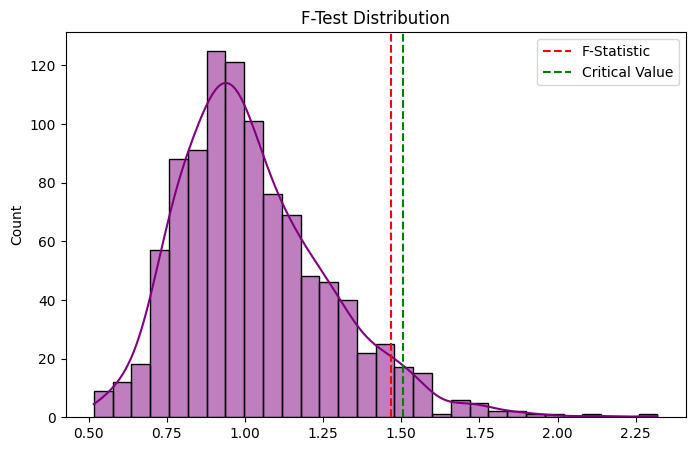

In [9]:
# F-Test for Variance
var_group1 = np.var(groups[0], ddof=1)
var_group2 = np.var(groups[1], ddof=1)
f_stat = var_group1 / var_group2
df1 = len(groups[0]) - 1
df2 = len(groups[1]) - 1
critical_value = f.ppf(0.95, df1, df2)

# F-Test Visualization
plt.figure(figsize=(8, 5))
sns.histplot(np.random.f(df1, df2, 1000), bins=30, kde=True, color='purple')
plt.axvline(f_stat, color='red', linestyle='--', label='F-Statistic')
plt.axvline(critical_value, color='green', linestyle='--', label='Critical Value')
plt.title('F-Test Distribution')
plt.legend()
plt.show()



PCA Reduced Dimensions: 5 components



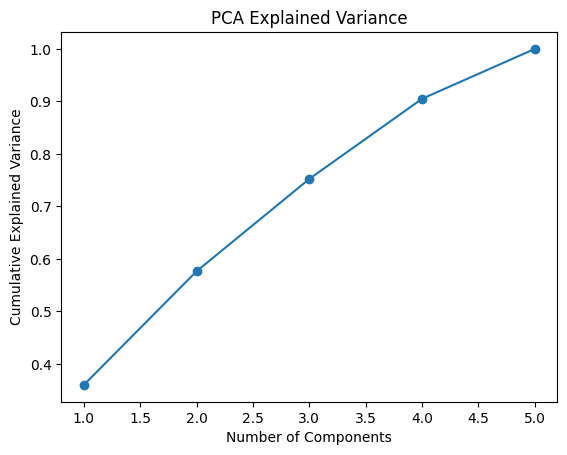

In [10]:
# PCA Analysis
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(data[continuous_features])
pca_variance = pca.explained_variance_ratio_

print(f"PCA Reduced Dimensions: {pca_data.shape[1]} components\n")

plt.plot(range(1, len(pca_variance) + 1), np.cumsum(pca_variance), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()


In [11]:
# Step 7: Feature Importance using Decision Tree
X = data.drop('target', axis=1)
y = data['target']
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)
feature_importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)


In [12]:

# Step 8: Final Feature Selection
final_features = list(set(significant_features + feature_importances.index[:5].tolist()))
print("Final Selected Features:", final_features)



Final Selected Features: ['sex', 'restecg', 'cp', 'slope', 'ca', 'oldpeak', 'thal', 'exang', 'chol']


In [13]:
# Normalize Data using MinMaxScaler
minmax_scaler = MinMaxScaler()
data[continuous_features] = minmax_scaler.fit_transform(data[continuous_features])


In [14]:
print("Preprocessing Completed.")

Preprocessing Completed.


In [18]:

# Load and preprocess dataset (Replace X, y with your actual dataset)
# X, y = some_preprocessed_dataframe.drop(columns=['target']), some_preprocessed_dataframe['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE before cross-validation
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define cross-validation strategy (10-fold for better generalization)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ensemble_accuracies = []
y_true_all = []
y_pred_all = []

# Define ANN Model
def create_ann_model(learning_rate=0.001, neurons=64, dropout_rate=0.3):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(neurons // 2, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate / 2),
        Dense(neurons // 4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning for KNN using GridSearchCV
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train_resampled)
best_knn = knn_grid.best_estimator_

# Manually tuned ANN hyperparameters
best_ann_params = {'learning_rate': 0.001, 'neurons': 128, 'dropout_rate': 0.3, 'epochs': 100, 'batch_size': 16}

for train_index, val_index in kfold.split(X_train_scaled, y_train_resampled):
    # Split into training and validation sets
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]

    # Apply SMOTE again to the training fold
    smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Train ANN with best parameters
    ann_model = create_ann_model(learning_rate=best_ann_params['learning_rate'],
                                 neurons=best_ann_params['neurons'],
                                 dropout_rate=best_ann_params['dropout_rate'])

    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint("best_ann_model.h5", save_best_only=True)

    ann_model.fit(X_train_fold_resampled, y_train_fold_resampled,
                  epochs=best_ann_params['epochs'], batch_size=best_ann_params['batch_size'],
                  verbose=0, callbacks=[early_stopping, model_checkpoint])
    y_pred_ann_prob = ann_model.predict(X_val_fold).flatten()

    # Train KNN with best parameters
    knn_model = best_knn
    knn_model.fit(X_train_fold_resampled, y_train_fold_resampled)
    y_pred_knn_prob = knn_model.predict_proba(X_val_fold)[:, 1]

    # Use Logistic Regression for Ensemble Learning
    meta_model = LogisticRegressionCV(cv=5, max_iter=1000)
    meta_features = np.column_stack((y_pred_ann_prob, y_pred_knn_prob))
    meta_model.fit(meta_features, y_val_fold)

    y_pred_ensemble = meta_model.predict(meta_features)

    # Store results for classification report
    y_true_all.extend(y_val_fold)
    y_pred_all.extend(y_pred_ensemble)

    # Compute accuracy for this fold
    ensemble_accuracy = accuracy_score(y_val_fold, y_pred_ensemble)
    ensemble_accuracies.append(ensemble_accuracy)




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


In [19]:
# Compute mean accuracy
mean_ensemble_accuracy = np.mean(ensemble_accuracies) * 100
print(f"\nMean Ensemble Model Accuracy: {mean_ensemble_accuracy:.2f}%")

# Generate final classification report
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=['Good (0)', 'Bad (1)']))




Mean Ensemble Model Accuracy: 87.02%

Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.88      0.86      0.87       131
     Bad (1)       0.86      0.88      0.87       131

    accuracy                           0.87       262
   macro avg       0.87      0.87      0.87       262
weighted avg       0.87      0.87      0.87       262




Confusion Matrix:
[[113  18]
 [ 16 115]]

TP: 115, TN: 113, FP: 18, FN: 16



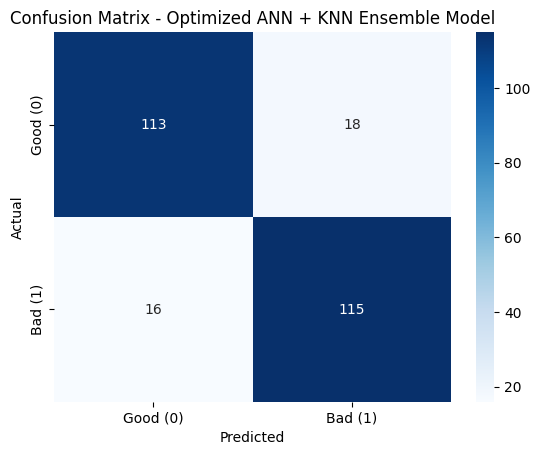

In [20]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Extract TP, TN, FP, FN
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

print("\nConfusion Matrix:")
print(conf_matrix)
print(f"\nTP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}\n")

# Heatmap for Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Good (0)', 'Bad (1)'], yticklabels=['Good (0)', 'Bad (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optimized ANN + KNN Ensemble Model')
plt.show()